# 0. QuickStart

## Working with data
API for common tasks in ML. Pytorch has two primitives to work with data:
- ```torch.utils.data.Dataset```
Dataset : sample과 대응되는 label 저장
- ```torch.utils.data.DataLoader```
DataLoader : Dataset을 순회 가능한 객체로 감싸줌


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

- ```from torchvision import datasets```
CIFAR, COCO와 같은 다양한 실제 비전 데이터에 대한 ```Dataset```을 포함하고 있는 모듈
- ```Dataset```
샘플(feature)과 정답을 각각 변경하기 위한 ```transform```과 ```target_transform```의 두 인자를 포함함

<br>

➝ DataLoader의 인자로 Dataset 전달
```DataLoader```
Dataset을 순회 가능한 객체로 감싸고, 자동화된 배치, 샘플링, shuffle, multoprocess data loading(다중 프로세스로 데이터 불러오기)을 지원함

In [ ]:
# Data Download

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11872286.68it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203101.92it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3769368.25it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15099494.40it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
batch_size = 64
# 데이터로더 객체의 각 요소는 64(batch_size)개의 feature와 label 묶음(batch)을 반환함

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models
- 신경망 모델 생성
1. ```nn.Module```을 상속받는 클래스 정의
2. ```__init__```함수 : 신경망의 layer들 정의
3. ```forward```함수 : 신경망에 데이터를 어떻게 전달할지 지정


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 모델 정의
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters
각 학습 단계(training loop)에서 모델은 batch로 제공되는 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 매개변수를 조정함

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 예측 오차 계산
    pred = model(X)
    loss = loss_fn(pred,y)

    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f} [{current:>5d} / {size:>5d}]")


def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"\nTest Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.862054 [   64 / 60000]
loss: 1.837057 [ 6464 / 60000]
loss: 1.703455 [12864 / 60000]
loss: 1.759035 [19264 / 60000]
loss: 1.638888 [25664 / 60000]
loss: 1.595901 [32064 / 60000]
loss: 1.620572 [38464 / 60000]
loss: 1.516352 [44864 / 60000]
loss: 1.548010 [51264 / 60000]
loss: 1.455388 [57664 / 60000]

Test Error: 
 Accuracy: 61.0%, Avg loss: 1.461204 

Epoch 2
-------------------------------
loss: 1.521329 [   64 / 60000]
loss: 1.497179 [ 6464 / 60000]
loss: 1.339967 [12864 / 60000]
loss: 1.428584 [19264 / 60000]
loss: 1.307949 [25664 / 60000]
loss: 1.304637 [32064 / 60000]
loss: 1.321797 [38464 / 60000]
loss: 1.242207 [44864 / 60000]
loss: 1.281370 [51264 / 60000]
loss: 1.198958 [57664 / 60000]

Test Error: 
 Accuracy: 64.0%, Avg loss: 1.211687 

Epoch 3
-------------------------------
loss: 1.276025 [   64 / 60000]
loss: 1.268485 [ 6464 / 60000]
loss: 1.099296 [12864 / 60000]
loss: 1.220576 [19264 / 60000]
loss: 1.097802 [25664 / 60000]

## Saving Models
 <u>모델의 매개변수들을 포함</u>하여 내부 상태 사전(internal state dictionary)을 직렬화(serialize)

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models
모델 구조를 다시 만들고 상태 사전을 불러옴

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 1. Tensors

- NumPy와 Tensor 차이
  - NumPy : 일반적인 ML을 위해 사용됨
  - Tensor : 무거운 행렬 연산에 최적화되어 GPU, TPU와 같은 가속기 메모리에서 사용 가능함

In [ ]:
import torch
import numpy as np

## Initializing a Tensor

In [ ]:
# 1. Directly from data
data = [[1,2], [3,4]]
x_data = torch.tensor(data)


# 2. From a NumPy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# 3. From another tensor
# override 하지 않는다면 인자로 주어진 텐서의 속성(shape, datatype) 유지
x_ones = torch.ones_like(x_data) # x_data : tensor
print(f"x_data: {x_data}\nshape: {x_data.shape}\ndatatype: {x_data.dtype}\n")
print(f"Ones Tensor: {x_ones}\nshape: {x_ones.shape}\ndatatype: {x_ones.dtype}\n")

x_rand = torch.rand_like(x_data, dtype = torch.float)
print(f"Random Tensor: {x_rand}\nshape: {x_rand.shape}\ndatatype: {x_rand.dtype}\n")

# 4. With random or constant values
shape = (2,3,) # shape : 튜플
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: {rand_tensor}\n")
print(f"Ones Tensor: {ones_tensor}\n")
print(f"Zeros Tensor: {zeros_tensor}")

x_data: tensor([[1, 2],
        [3, 4]])
shape: torch.Size([2, 2])
datatype: torch.int64

Ones Tensor: tensor([[1, 1],
        [1, 1]])
shape: torch.Size([2, 2])
datatype: torch.int64

Random Tensor: tensor([[0.9673, 0.2373],
        [0.3187, 0.2378]])
shape: torch.Size([2, 2])
datatype: torch.float32

Random Tensor: tensor([[0.0770, 0.0633, 0.0747],
        [0.8927, 0.9347, 0.9897]])

Ones Tensor: tensor([[1., 1., 1.],
        [1., 1., 1.]])

Zeros Tensor: tensor([[0., 0., 0.],
        [0., 0., 0.]])


## Attributes of a Tensor
- shape  
- datatype  
- 저장된 device


In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Operations on Tensors
- arithmetic
- linear algebra
- matrix manipulation(transposing, indexing, slicing)
- sampling  
등의 연산 가능함

In [ ]:
# tensor : 기본적으로 CPU에서 생성되는데 .to() 메소드를 통해 GPU로 이동 가능함
if torch.cuda.is_available():
  tensor = tensor.to("cuda")

### Standard numpy-like indexing and slicing

In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}") # 행
print(f"First column: {tensor[:, 0]}") # 열
print(f"Last column: {tensor[..., -1]}")

tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### Joining tensors
- ```torch.cat``` : 주어진 차원에 따라 텐서 연결 (= list의 ```extend```)
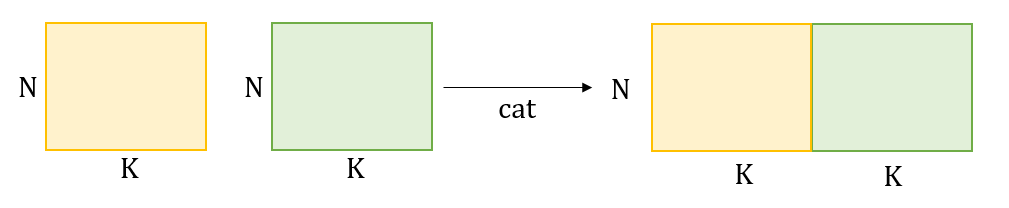

- ```torch.stack``` : 새로운 차원으로 텐서 연결 (= 주어진 텐서들을 새로운 차원으로 합친다)
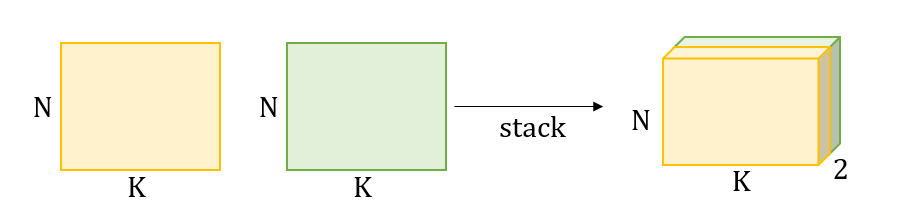

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim = 1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [ ]:
# torch.cat과 torch.stack 차이
t1 = torch.tensor([[1,2], [3,4]])
t2 = torch.tensor([[5,6], [7,8]])

print(f"torch.cat(dim = 0):\n {torch.cat((t1, t2), dim = 0)}\n{torch.cat((t1, t2), dim = 0).shape}\n") # 행방향 연결
print(f"torch.cat(dim = 1):\n {torch.cat((t1, t2), dim = 1)}\n{torch.cat((t1, t2), dim = 1).shape}\n") # 열방향 연결
print(f"torch.stack:\n {torch.stack((t1, t2))}\n{torch.stack((t1, t2)).shape}")

torch.cat(dim = 0):
 tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])
torch.Size([4, 2])

torch.cat(dim = 1):
 tensor([[1, 2, 5, 6],
        [3, 4, 7, 8]])
torch.Size([2, 4])

torch.stack:
 tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])
torch.Size([2, 2, 2])


### Arithmetic operations (산술 연산)

In [ ]:
# 행렬 곱 (matrix multiplication)
y1 =  tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out = y3)

print(f"y1: {y1}\ny2: {y2}\ny3: {y3}")
print()

# 요소별 곱 (element-wise product)
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out = z3)

print(f"z1: {z1}\nz2: {z2}\nz3: {z3}")

y1: tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
y2: tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
y3: tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

z1: tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
z2: tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
z3: tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### Single-element tensors
: 텐서의 요소가 하나인 경우 ```item()```을 통해 Python 숫자 값으로 변환 가능

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(f"agg.item: {agg_item}\tdatatype: {type(agg_item)}")

Shape of agg: torch.Size([])
agg.item: 12.0	datatype: <class 'float'>


### In-place operations (바꿔치기 연산)
: 연산 결과를 피연산자에게 저장하는 연산  
```copy```, ```T```와 같은 연산 함수 뒤에 ```_```를 붙임

In [ ]:
print(f"{tensor}\n")
tensor.add_(5) # == tensor += 5
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


## Bridge with NumPy
CPU에 있는 Tensor와 Numpy 배열은 메모리 공간을 공유하기 때문에 하나를 변경하면 다른 하나도 변경됨

In [ ]:
# Tensor ⇒ NumPy array
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

print()
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [ ]:
# NumPy array ⇒ Tensor
n = np.ones(5)
t = torch.from_numpy(n)
print(f"n: {n}")
print(f"t: {t}")

print()
np.add(n, 1, out = n)
print(f"n: {n}")
print(f"t: {t}")

n: [1. 1. 1. 1. 1.]
t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

n: [2. 2. 2. 2. 2.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


# 2. DATASETS & DATALOADERS
[참고 사이트](https://velog.io/@idj7183/PyTorch2-DataSet-DataLoader-Transform)

- 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드는 모델 학습 코드와 분리하는 것을 권장함

  - ```torch.utils.data.Dataset``` : 샘플과 label 저장
    - 모델에 전달할 데이터의 입력형태를 정의하는 클래스
    - 하나의 샘플에 하나의 label을 지정함

  - ```torch.utils.data.DataLoader``` : ```Dataset```을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감싸는 역할
    - ```Dataset```에서 처리한 Data의 Batch를 생성해주는 클래스  
    모델을 학습할 때, 샘플들을 하나씩이 아닌 ***미니배치***로 전달하고, 매 에폭마다 데이터를 다시 섞어서 오버피팅을 막고, Python의 ```multiprocessing```을 사용하여 데이터 검색 속도를 높이고자 함  

    ⇒ ```DataLoader``` : 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체

## Loading a Dataset
- ```root``` : 데이터가 저장되는 경로
- ```train``` : 학습용 / 테스트용 여부 결정
- ```download = True``` : ```root```에 데이터가 없는 경우 인터넷에서 다운로드함
- ```transform```과 ```target_transform``` : feature와 label의 변형(transform) 지정함
  - Data를 변형시키는 방법으로,
    - image의 size 변경
    - numpy를 torch 형식으로 변경  
 등의 작업을 수행함

In [ ]:
# pre-loaded된 데이터셋 사용
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12307926.74it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 213330.21it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3955682.21it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5288336.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Iterating and Visualizing the Dataset
```Dataset```에 list처럼 직접 접근(index) 가능함

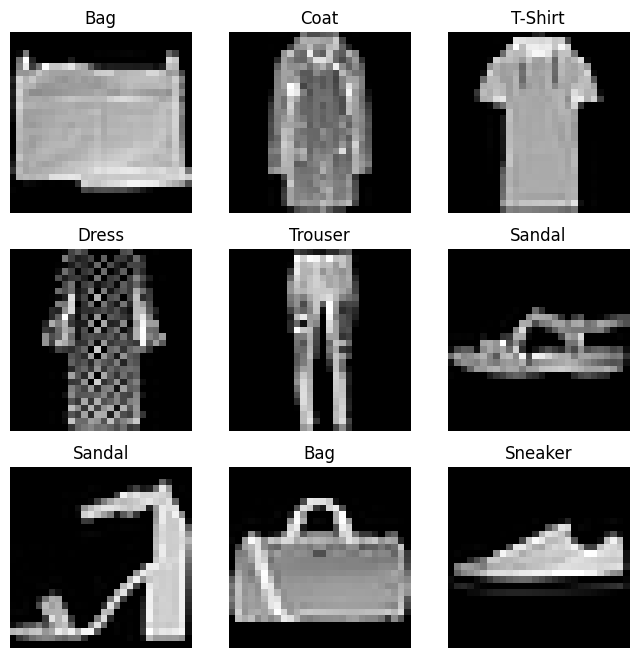

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files (사용자 정의 데이터셋 만들기)
아래 3가지 함수 반드시 구현해야 함
- ```__init__``` : ```Dataset``` 객체가 생성될 때 한 번만 실행되는 함수  
- ```__len__``` : 데이터셋의 샘플 개수를 반환하는 함수  
- ```__getitem__``` : 주어진 인덱스 ```idx```에 해당하는 샘플을 데이터셋에서 불러오고 반환하는 함수


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # 디스크에서 이미지 위치 식별
        image = read_image(img_path) # 이미지 → 텐서
        label = self.img_labels.iloc[idx, 1] # 해당하는 정답 라벨
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label # 텐서 이미지와 라벨을 dict 형으로 반환

## Preparing your data for training with ```DataLoaders```


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterating through the DataLoader  
위에서 설정한 ```batch_size```대로 64개의 train_features와 train_labels 묶음을 반환함  
```shuffle = True``` : 모든 배치를 순회한 뒤 데이터가 섞임

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


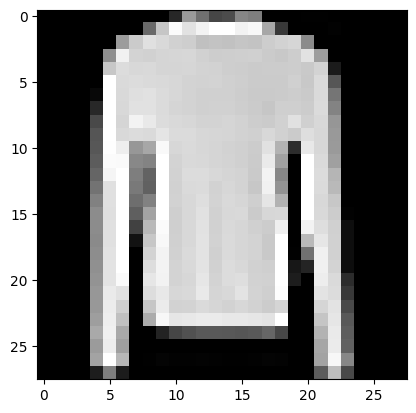

Label: 2


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 3. TRANSFORMS

<u>변형</u>을 통해 데이터를 조작하고 <u>학습에 적합하게</u> 만듦  
예) 샘플들이 다 같은 사이즈가 아닌 경우
  - Rescale: 이미지의 크기 조절
  - RandomCrop : 이미지를 무작위로 자름
  - ToTensor : 축변환으로 numpy 이미지 → torch 이미지
  ***

  Fashion MNIST
  - feature : PIL Image → normalize된 텐서
    - ```ToTensor```
      - PIL Image, NumPy ndarray → FloatTensor 변환   
      - 이미지 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 scale

  - label : 정수 → one-hot encoding된 텐서
    - ```Lambda``` transform
    0. 클래스 개수(10개)만큼 zero tensor 만들기
    1. ```scatter_```로 주어진 label y에 해당하는 인덱스는 1로 변경하기
      - ```scatter``` : 파라미터로 주어진 인덱스(torch.tensor(y))에 맞게 기존 값(0)을 주어진 value(1)로 바꿈

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # feature transform
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) # label transform
)

# 4. BUILD THE NEURAL NETWORK

- ```torch.nn``` : 신경망을 구성하는 데 필요한 모든 구성 요소 제공
- ```torch.nn.Module``` : 모든 PyTorch 모듈(layer)의 상위 클래스


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get Device for Training

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Define the Class
0. 신경망 모델을 ```nn.Module```의 하위클래스로 정의하기
1. ```__init__```에서 layer들 초기화하기
2. ```forward``` 메소드에 입력 데이터에 대한 연산 구현하기  
  *```forward```함수는 직접 호출하면 안됨*
3. ```NerualNetwork```의 인스턴스 생성하고 ```device```로 이동하기

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x): # nn.Module을 상속받은 모든 클래스는 forward 함수가 필요함
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X) # 모델에 입력 데이터 전달 → 백그라운드 연산과 함께 forward 함수 실행
# logits ⇒ dim = 0: 실제 정답 label 값 / dim = 1: 예측 label 값
print(f"model returns:\n{logits}\n")

pred_probab = nn.Softmax(dim=1)(logits) # 예측 확률 얻기
print(f"predicted probability:\n{pred_probab}\n")

y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

model returns:
tensor([[ 0.0525,  0.0837, -0.1044,  0.0263, -0.0156,  0.0303, -0.0312,  0.0301,
          0.0394, -0.0099]], grad_fn=<AddmmBackward0>)

predicted probability:
tensor([[0.1042, 0.1075, 0.0891, 0.1015, 0.0973, 0.1019, 0.0958, 0.1019, 0.1028,
         0.0979]], grad_fn=<SoftmaxBackward0>)

Predicted class: tensor([1])


## Model Layers


In [ ]:
input_image = torch.rand(3,28,28) # 28x28 크기의 이미지 3개로 구성된 미니배치
print(input_image.size())

torch.Size([3, 28, 28])


### ```nn.Flatten```
dim = 0의 미니배치 차원은 유지하면서 2D 이미지를 28*28개의 픽셀값을 갖는 연속된 배열로 변환하는 층

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### ```nn.Linear```
저장된 weight와 bias를 사용하여 입력에 선형 변환을 적용하는 층

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### ```nn.ReLU```
선형 변환된 입력에 비선형성을 더해주는 활성화 함수 층
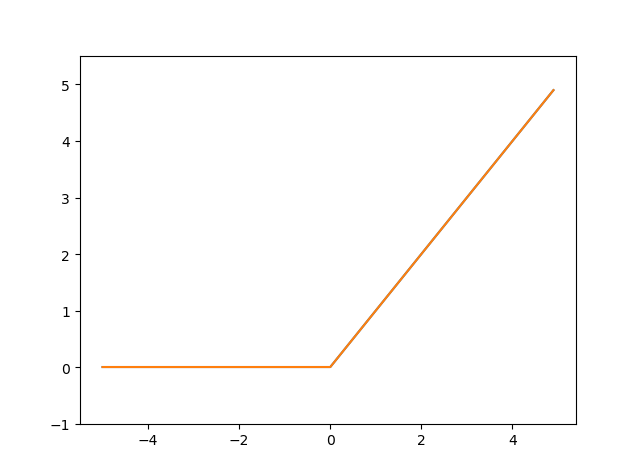

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.1198,  0.3118,  0.6347, -0.0439, -0.0342,  0.8635,  0.0227,  0.0480,
         -0.4264, -0.3854, -0.1006,  0.2797, -0.0556,  0.2937, -0.3904, -0.4081,
          0.0269,  0.1187, -0.0872,  0.2706],
        [-0.1637,  0.4484,  0.0932,  0.0136, -0.1803,  0.3373,  0.2526,  0.5075,
         -0.0389, -0.0885, -0.0983,  0.2453, -0.2813, -0.3531,  0.1489, -0.4932,
          0.0815,  0.1267, -0.3530,  0.2324],
        [ 0.0161,  0.0358,  0.1261, -0.2642, -0.4071,  0.3056,  0.1434,  0.4104,
         -0.5709, -0.4637, -0.3689, -0.0671, -0.4682, -0.0364, -0.0329, -0.0924,
         -0.0699, -0.0196, -0.0652,  0.2023]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1198, 0.3118, 0.6347, 0.0000, 0.0000, 0.8635, 0.0227, 0.0480, 0.0000,
         0.0000, 0.0000, 0.2797, 0.0000, 0.2937, 0.0000, 0.0000, 0.0269, 0.1187,
         0.0000, 0.2706],
        [0.0000, 0.4484, 0.0932, 0.0136, 0.0000, 0.3373, 0.2526, 0.5075, 0.0000,
         0.0000, 0.0000, 0.2453, 0.0000, 0.0000, 0.14

### ```nn.Sequential```
순서를 갖는 컨테이너로, 정의된 layer 순서대로 데이터가 layer에 전달됨  
+) 신경망을 더 빠르게 만들 수 있음

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### ```nn.Softmax```
= 각 클래스일 확률   
[logit, sigmoid, softmax](https://velog.io/@guide333/logit-%ED%99%95%EB%A5%A0-sigmoid-softmax)   
마지막 선형층에서 반환되는 logits([-∞, ∞])와 같은 Shape의 텐서를 반환하는데 이때 모든 값은 [0, 1] 범위에 있음  
텐서의 총합 = 1

## Model Parameters
- ```torch.nn.Module.parameters``` :  모델의 각 층마다의 파라미터 값을 추출하는 함수
- ```torch.nn.Module.named_parameters``` :  모델의 각 층의 명칭과 파라미터 값을 추출하는 함수

In [ ]:
for param in model.parameters():
    print(f"Size: {param.size()} | Values : {param[:2]} \n")

Size: torch.Size([512, 784]) | Values : tensor([[-0.0183, -0.0198,  0.0002,  ..., -0.0278, -0.0214,  0.0319],
        [-0.0065,  0.0294,  0.0018,  ..., -0.0219, -0.0167, -0.0237]],
       grad_fn=<SliceBackward0>) 

Size: torch.Size([512]) | Values : tensor([-0.0242,  0.0210], grad_fn=<SliceBackward0>) 

Size: torch.Size([512, 512]) | Values : tensor([[-0.0436,  0.0342,  0.0192,  ...,  0.0088, -0.0330, -0.0379],
        [-0.0317,  0.0386, -0.0156,  ..., -0.0103,  0.0222, -0.0311]],
       grad_fn=<SliceBackward0>) 

Size: torch.Size([512]) | Values : tensor([0.0013, 0.0358], grad_fn=<SliceBackward0>) 

Size: torch.Size([10, 512]) | Values : tensor([[-0.0158,  0.0333,  0.0331,  ...,  0.0244, -0.0433,  0.0404],
        [ 0.0173,  0.0054, -0.0077,  ..., -0.0167, -0.0052, -0.0142]],
       grad_fn=<SliceBackward0>) 

Size: torch.Size([10]) | Values : tensor([0.0180, 0.0342], grad_fn=<SliceBackward0>) 



In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0183, -0.0198,  0.0002,  ..., -0.0278, -0.0214,  0.0319],
        [-0.0065,  0.0294,  0.0018,  ..., -0.0219, -0.0167, -0.0237]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0242,  0.0210], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0436,  0.0342,  0.0192,  ...,  0.0088, -0.0330, -0.0379],
        [-0.0317,  0.0386, -0.0156,  ..., -0.0103,  0.0222, -0.0311]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# 5. AUTOMATIC DIFFERENTIATION WITH ```TORCH.AUTOGRAD```

## Tensors, Functions and Computational graph
***backpropagation*** : 손실 함수의 변화도(기울기; gradient)에 따라 파라미터(가중치)가 업데이트 됨  
+) PyTorch에는 기울기 계산하는 자동 미분 엔진 ```torch.autograd``` 내장되어 있음
***
```w, b``` : 최적화해야 할 파라미터 ⇒ ```requires_grad = True```  

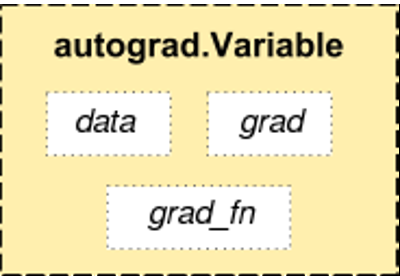  
각 변수들은 클래스로 data, grad, grad_fn 속성을 가짐  
텐서.```grad_fn``` : 역전파에 대한 참조 정보

In [ ]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad = True)
'''
# 먼저 텐서 생성한 후 자동미분 설정해도 됨
w = torch.randn(5, 3)
w.requires_grad_(True)
'''
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7fa6a202d780>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7fa6a202f460>


## Computing Gradients
도함수를 계산하기 위해 ```loss.backward()``` 호출하기  
➝ backpropagation을 시작할 지점의 tensor에서 ```.backward()``` 호출


In [ ]:
loss.backward()
print(w.grad) # requires_grad = True한 텐서의 gradient값 확인 가능
print(b.grad)

tensor([[0.3331, 0.2300, 0.0619],
        [0.3331, 0.2300, 0.0619],
        [0.3331, 0.2300, 0.0619],
        [0.3331, 0.2300, 0.0619],
        [0.3331, 0.2300, 0.0619]])
tensor([0.3331, 0.2300, 0.0619])



```.backward()```를 호출할 객체가 스칼라인 경우 별도의 인자를 지정할 필요가 없지만, 아닐 경우 텐서의 크기(텐서)를 인자로 전달해야 함  
- 디폴트 : ```.backward(torch.tensor([1], dtype = torch.float))```  
PyTorch에서는 backward()를 한 번 수행하여 기울기가 계산되면 이를 계산하기 위한 중간 결과값들이 없어짐 ⇔ 한 그래프에서 한 번의 기울기 계산만 가능함  
⇒ 동일한 그래프에서 여러번의 ```backward()```을 호출하고 싶다면 ```.backward(retain_graph = True)```

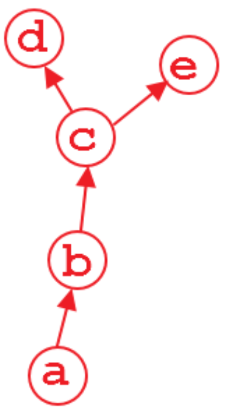

In [ ]:
from torch.autograd import Variable
import torch

a = Variable(torch.rand(1,4), requires_grad = True)
b = a**2
c = b*2
d = c.mean()
e = c.sum()

```d.backward()``` 실행 시 b → c → b → a에 대한 정보가 사라짐  
```d.backward(retain_graph = True)```로 정보를 버리지 않을 것임을 명시해줘야 동일 그래프에서 기울기 계산 여러번 가능함

In [ ]:
d.backward()
e.backward()

RuntimeError: ignored

In [ ]:
d.backward(retain_graph=True)
e.backward()

## Disabling Gradient Tracking
```requires_grad = True```인 텐서들은 연산 기록을 추적하고 기울기 계산을 지원하는데, 순전파 연산만 필요한 경우 이러한 기능 필요없음    
 ⇒   
 방법 1. ```torch.no_grad()```블록으로 둘러싸서 연산 추적을 멈출 수 있음 = 이 구역 안에 있는 텐서는 기울기를 기록하지 않음  
 방법 2. ```.detach()``` 적용하여 연산 추적을 멈출 수 있음  

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


## More on Computational Graphs
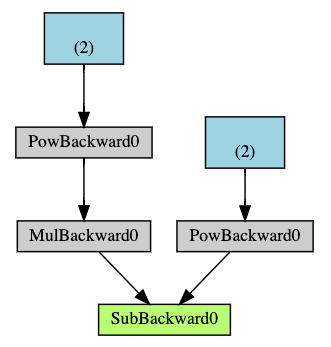

- ```autograd```는 텐서의 모든 연산을 그림과 같이 *방향성 비순환 그래프(DAG)*로 기록함  
  - root인 연두색 노드에서 ```.backward()```가 호출되면 연쇄법칙을 통해 파란색 lead node까지 역전파가 실행됨
- Dynamic 그래프
= 미리 그래프를 정의하고 연산하지 않고 실행 시점에 그래프가 생성됨  
 ⇒ 한 번의 forward에 그래프가 생성되고 ```.backward()``` 시 그래프가 초기화됨


## [Optional Reading: Tensor Gradients and Jacobian Products](https://velog.io/@olxtar/PyTorch-Autograd-with-Jacobian)
출력 함수가 임의의 텐서가 아닌 경우 실제 변화도가 아닌 Jacobian product을 계산함

# 6. OPTIMIZING MODEL PARAMETERS

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

100%|██████████| 26421880/26421880 [00:01<00:00, 17619459.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297385.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5496013.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9275033.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Hyperparameters
: 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## Optimization Loop
- epoch : 최적화 단계의 각 반복(iteration)
하나의 epoch은 두 부분으로 구성됨
  - train loop : train dataset을 반복(iterate)하고 최적의 매개변수로 수렴함
  - validation/test loop : 모델의 성능이 개선되고 있는지 확인하기 위해 test dataset을 반복(iterate)함

#### train loop
- loss function  
: 실제 정답과 예측 값 사이의 틀린 정도를 측정하며, 이를 최소화하는 것이 학습의 목표임
- optimizer  
: 각 학습 단계에서 오차를 줄이기 위해 모델의 매개변수를 조정하는 과정  
  1. ```optimizer.zero_grad()``` : 기울기 값이 누적되는 것을 방지하고자 매 epoch마다 모델 매개변수의 기울기 재설정 해야 함
  2. ```loss.backward()``` : 예측 손실 역전파하여 각 매개변수에 대한 loss의 변화도를 저장함
  3. ```optimizer.step()``` : 역전파 단계에서 수집된 변화도로 매개변수 업데이트

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300999  [   64/60000]
loss: 2.288015  [ 6464/60000]
loss: 2.264078  [12864/60000]
loss: 2.260151  [19264/60000]
loss: 2.249620  [25664/60000]
loss: 2.209846  [32064/60000]
loss: 2.228636  [38464/60000]
loss: 2.189424  [44864/60000]
loss: 2.185588  [51264/60000]
loss: 2.159149  [57664/60000]
Test Error: 
 Accuracy: 39.0%, Avg loss: 2.151920 

Epoch 2
-------------------------------
loss: 2.162842  [   64/60000]
loss: 2.152559  [ 6464/60000]
loss: 2.088736  [12864/60000]
loss: 2.113718  [19264/60000]
loss: 2.063494  [25664/60000]
loss: 1.995055  [32064/60000]
loss: 2.037613  [38464/60000]
loss: 1.952590  [44864/60000]
loss: 1.959732  [51264/60000]
loss: 1.897521  [57664/60000]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.886051 

Epoch 3
-------------------------------
loss: 1.920577  [   64/60000]
loss: 1.888309  [ 6464/60000]
loss: 1.765994  [12864/60000]
loss: 1.820040  [19264/60000]
loss: 1.702180  [25664/60000]
loss: 1.649848  [32064/600

# 7. SAVE AND LOAD THE MODEL

In [ ]:
import torch
import torchvision.models as models

## Saving and Loading Model Weights
- ```state_dict``` : 학습한 매개변수가 ```torch.save```를 통해 internal state dictionary에 저장됨  
- ```load_state_dict()```을 통해 저장된 매개변수들을 불러옴 (동일한 모델의 인스턴스 생성한 후에 매개변수를 불러와야 함)


In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), "model_weights.pth")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 97.3MB/s]


```.eval()```: 모델을 평가모드로 전환하는 함수  
= evaluation 과정에서 사용하지 않아야 하는 층들을 알아서 off하는 함수 (드롭아웃 비활성화&배치 정규화의 이동평균과 이동 분산이 업데이트되지 않음)  
+) evaluation / validation 과정에서 보통 ```model.eval()```과 ```torch.no_grad()```를 함께 사용함  
→ 모델의 성능 평가에 불필요한 노이즈를 줄이고 일관된 결과를 얻을 수 있음

In [ ]:
model = models.vgg16() # weights를 지정하지 않음 ⇔ 학습되지 않은 모델
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Saving and Loading Models with Shapes
- ```torch.save(model.state_dict())```와 달리 모델 전체를 저장

In [ ]:
torch.save(model, 'model.pth') # 모델 저장
model = torch.load('model.pth') # 모델 불러오기